In [1]:
# RECOPILACIÓN Y CARGA DE DATOS
import pandas as pd
from pathlib import Path
import numpy as np

df_ventas = pd.read_csv('https://drive.google.com/uc?id=1ZFhhEIk4B91XDkDXfveVvkUrJ3u6mo5J&export=download')
df_clientes = pd.read_csv('https://drive.google.com/uc?id=1czywsYrIO0UYRzLO12uC26O2S_Hx8WF4&export=download')
df_marketing = pd.read_csv('https://drive.google.com/uc?id=1hJBz9eoE-ljUEC9FnFN713Oj--7GzZQq&export=download')

In [2]:
# ANÁLISIS EXPLORATORIO INICIAL de los Dataframes

def resumen(df, nombre):
    print(f"Resumen de {nombre}:")
    df.info()
    print(f"-------------------------\n")

dfs = [(df_ventas, "Ventas"), (df_clientes, "Clientes"), (df_marketing, "Marketing")]

for df, nombre in dfs:
    resumen(df, nombre)

Resumen de Ventas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3035 entries, 0 to 3034
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id_venta     3035 non-null   int64  
 1   producto     3035 non-null   object 
 2   precio       3033 non-null   object 
 3   cantidad     3033 non-null   float64
 4   fecha_venta  3035 non-null   object 
 5   categoria    3035 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 142.4+ KB
-------------------------

Resumen de Clientes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567 entries, 0 to 566
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id_cliente  567 non-null    int64  
 1   nombre      567 non-null    object 
 2   edad        567 non-null    int64  
 3   ciudad      567 non-null    object 
 4   ingresos    567 non-null    float64
dtypes: float64(1), int64(2), object

In [3]:
# NORMALIZACIÓN DE DATOS

# Ventas
df_ventas["precio"] = (df_ventas["precio"]
                        .astype(str).str.replace(r"[$,\s]", "", regex=True)
                        .replace({"nan": np.nan}).infer_objects(copy=False))   # Convierte valores faltantes en nulos reales para que pandas lo reconozca
df_ventas["precio"] = pd.to_numeric(df_ventas["precio"], errors="coerce") # convierte a numérico (float), los errores los convierte en NaN

df_ventas["fecha_venta"] = pd.to_datetime(df_ventas["fecha_venta"], dayfirst=True, errors="coerce")

# Marketing
for col in ["fecha_inicio", "fecha_fin"]:
    df_marketing[col] = pd.to_datetime(df_marketing[col], dayfirst=True, errors="coerce")

In [4]:
# CALIDAD DE DATOS

# Identificar valores nulos y duplicados en los conjuntos de datos.
precio_nulo = df_ventas["precio"].isna().sum()
cantidad_nulo = df_ventas["cantidad"].isna().sum()
print(f"Cantidad de nulos en 'precio': {precio_nulo}")
print(f"Cantidad de nulos en 'cantidad': {cantidad_nulo}")

for df, nombre in dfs:
    dups = df.duplicated().sum()
    print(f"Duplicados en {nombre}: {dups}")

Cantidad de nulos en 'precio': 2
Cantidad de nulos en 'cantidad': 2
Duplicados en Ventas: 35
Duplicados en Clientes: 0
Duplicados en Marketing: 0


In [5]:
# LIMPIEZA DE DATOS

# Eliminar duplicados
df_ventas = df_ventas.drop_duplicates().copy()

# Eliminar filas de "precios" en blanco (no tiene sentido tener una venta sin precio)
df_ventas = df_ventas[df_ventas["precio"].notna()].copy()

# Reemplazar filas de "cantidad" en blanco --> 0 (puede ser un error donde nunca se agregó la cantidad vendida)
df_ventas["cantidad"] = df_ventas["cantidad"].fillna({"cantidad": 0})


In [6]:
# TRANSFORMACIÓN ANALÍTICA DE DATOS

# Agregación analítica: total de ingresos por mes
df_ventas["importe"] = df_ventas["precio"] * df_ventas["cantidad"]

df_ventas_mensuales = df_ventas.copy()
df_ventas_mensuales["mes"] = df_ventas_mensuales["fecha_venta"].dt.month

MESES_NOMBRE = {
    1:"Enero", 2:"Febrero", 3:"Marzo", 4:"Abril", 5:"Mayo", 6:"Junio", 7:"Julio", 8:"Agosto", 9:"Septiembre", 10:"Octubre", 11:"Noviembre", 12:"Diciembre"
}

ventas_mensuales = df_ventas_mensuales.groupby("mes")["importe"].sum()
ventas_mensuales = ventas_mensuales.reset_index(drop=False)
ventas_mensuales.index = ventas_mensuales.index + 1
ventas_mensuales["mes"] = ventas_mensuales["mes"].map(MESES_NOMBRE)

print(f"Ventas mensuales: \n{ventas_mensuales}")


# Transformación estructural: almacenar los datos de ventas (producto, precio, cantidad) en un diccionario
ventas_lista = df_ventas[["producto", "precio", "cantidad"]].to_dict("records") # Convierte las columnas seleccionadas en una lista de diccionarios

print("\nDatos de las Ventas Totales:")
for datos_venta in ventas_lista[:5]:
    print(datos_venta)


# Agregación por categoría: eesumir las ventas por categoría de producto y analizar los ingresos generados.
ventas_categoricas = df_ventas.groupby("categoria").agg(
    cantidad_vendida = ("cantidad", "sum"),
    ingresos = ("importe", "sum")
)
print(f"\n {ventas_categoricas}")

Ventas mensuales: 
           mes    importe
1        Enero  129604.99
2      Febrero  118672.44
3        Marzo  136779.15
4        Abril  128430.69
5         Mayo  143727.25
6        Junio  108480.17
7        Julio  116229.97
8       Agosto  119680.15
9   Septiembre  115787.85
10     Octubre  112117.13
11   Noviembre  119951.79
12   Diciembre  117631.94

Datos de las Ventas Totales:
{'producto': 'Cuadro decorativo', 'precio': 69.94, 'cantidad': 5.0}
{'producto': 'Lámpara de mesa', 'precio': 105.1, 'cantidad': 5.0}
{'producto': 'Secadora', 'precio': 97.96, 'cantidad': 3.0}
{'producto': 'Heladera', 'precio': 114.35, 'cantidad': 8.0}
{'producto': 'Secadora', 'precio': 106.21, 'cantidad': 4.0}

                    cantidad_vendida   ingresos
categoria                                     
Decoración                   6490.0  479216.09
Electrodomésticos            6592.0  505299.63
Electrónica                  6413.0  482577.80


In [7]:
# Top 10 productos con mayores ingresos
top10_productos = (df_ventas
                 .groupby("producto", as_index=False)
                 .agg(total_ingresos=("importe", "sum"))
                 .sort_values("total_ingresos", ascending=False)
                 .head(10))



In [8]:
# Gráficos
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots

# barras horizontales Top 10 productos con mayores ingresos
# línea ingresos por mes
# Demografía de clientes por edad con 2 colores por sexo
# Boxplot – Ingresos por ciudad, ciudad mas rentables
# Retorno Inversión por Beneficio
# barra ROI por canal (ROI = ingresos - costo marketing / costo marketing)

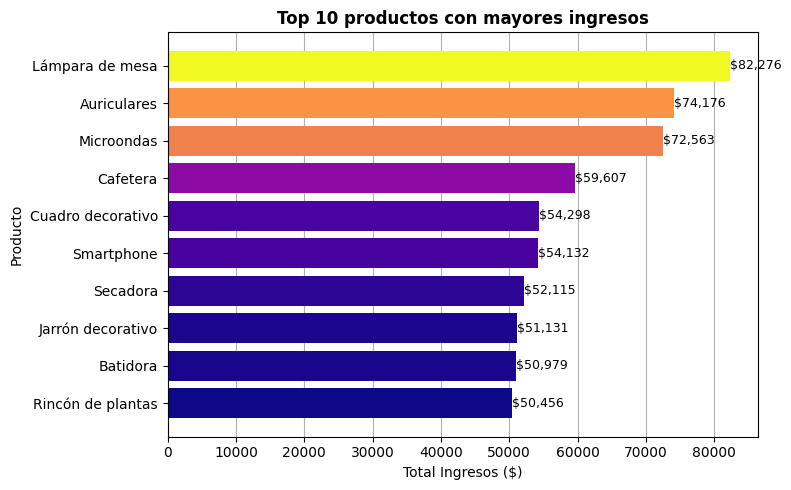

In [9]:
# GRÁFICOS MATPLOTLIB
plt.rcParams['axes.axisbelow'] = True #  Queda el grid atrás del gráfico

# Top 10 productos con mayores ingresos
fig, ax = plt.subplots(figsize=(8,5))
norm = plt.Normalize(vmin=min(top10_productos["total_ingresos"]), vmax=max(top10_productos["total_ingresos"]))
colors = plt.cm.plasma(norm(top10_productos["total_ingresos"]))

bars = ax.barh(top10_productos["producto"], top10_productos["total_ingresos"], color=colors)

ax.set_title("Top 10 productos con mayores ingresos", fontweight="bold")
ax.set_xlabel("Total Ingresos ($)")
ax.set_ylabel("Producto")
ax.invert_yaxis()

ax.grid(True, axis="x")

# Etiquetas de datos
for i, (bar, valor) in enumerate(zip(bars, top10_productos['total_ingresos'])):
    ax.text(valor, bar.get_y() + bar.get_height()/2, 
            f'${valor:,.0f}', 
            va='center', ha='left', fontsize=9)
    
plt.tight_layout()
plt.show()

C:\Users\david\AppData\Local\Temp\ipykernel_23000\2188863932.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


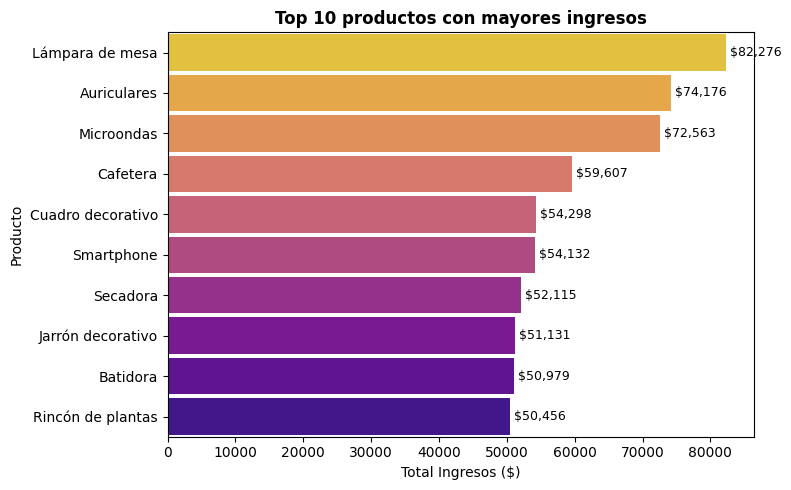

In [10]:
# GRÁFICOS SEABORN

# Top 10 productos con mayores ingresos
fig, ax = plt.subplots(figsize=(8,5))

sns.barplot(
    data=top10_productos,
    x="total_ingresos",
    y="producto",
    palette=list(reversed(sns.color_palette("plasma", n_colors=len(top10_productos)))),
    ax=ax,
    width=0.9,
    orient="h"
)

ax.set_title("Top 10 productos con mayores ingresos", fontweight="bold")
ax.set_xlabel("Total Ingresos ($)")
ax.set_ylabel("Producto")

for container in ax.containers: 
    ax.bar_label(container,
                 fmt='${:,.0f}', 
                 label_type='edge',
                 padding=3, 
                 fontsize=9)

plt.tight_layout()
plt.show()


#

In [11]:
# PLOTLY EXPRESSS
fig = make_subplots(
    rows=3, cols=2,
    subplot_titles=(
        "Top 10 productos con mayores ingresos",
        "Ingresos Mensuales",
        "Demografía de Clientes",
        "Ingresos por ciudad",
        "Retorno Inversión por Beneficio",
        "ROI por canal de marketing"
    ),
    specs=[
        [{"type": "bar"}, {"type": "bar"}],
        [{"type": "heatmap"}, {"type": "box"}],
        [{"type": "bar"}, {"type": "bar"}]
    ]
)

# Top 10 productos con mayores ingresos
bar1 = px.bar(
        data_frame=top10_productos,
        x="total_ingresos",
        y="producto",
        orientation="h",
        text=top10_productos["total_ingresos"].round(0),
        color="total_ingresos",
        color_discrete_sequence=px.colors.sequential.Plasma_r,
        range_color=(top10_productos["total_ingresos"].min(), top10_productos["total_ingresos"].max())
)

fig.add_trace(bar1.data[0], row=1, col=1)
fig.update_yaxes(autorange="reversed", row=1, col=1)
fig.update_layout(
    coloraxis_showscale=False,
    plot_bgcolor="white",
    xaxis=dict(showgrid=True, gridcolor="lightgrey", dtick=10000),   
    xaxis_title="Total Ingresos ($)",
    yaxis_title="Producto",
    height=1000,
    width=1200
)

fig.update_traces(
    texttemplate='$%{text:,.0f}'
)

fig.show()
